# 15. Transfer Learning with Inception v3

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import models
import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 15.1 Prepare Data

In [3]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
#     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
#     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_data = dsets.ImageFolder('data/squir_chip_data/train/', train_transform)
test_data = dsets.ImageFolder('data/squir_chip_data/val/', test_transform)

In [4]:
batch_size = 5

train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=1)

test_loader = DataLoader(test_data, 
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=1)

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

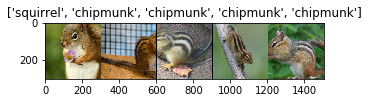

In [6]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images, normalize=True), [train_data.classes[i] for i in labels])

## 15.2 Define Model

In [7]:
model = models.inception_v3(pretrained=True)

In [8]:
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [9]:
model.aux_logits = False

fine_tune = False

if not fine_tune:
    for parameter in model.parameters():
        parameter.requires_grad = False

In [10]:
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 10),
    nn.Linear(10, 2)
)

In [11]:
model = model.cuda()

In [12]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

## 15.3 Train Model

In [13]:
num_epochs = 30

In [14]:
for epoch in range(num_epochs):
    
    total_batch = len(train_data)//batch_size

    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 5 == 0:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

Epoch [1/30], lter [5/28] Loss: 1.8617
Epoch [1/30], lter [10/28] Loss: 0.4617
Epoch [1/30], lter [15/28] Loss: 0.6188
Epoch [1/30], lter [20/28] Loss: 0.7723
Epoch [1/30], lter [25/28] Loss: 0.6561
Epoch [2/30], lter [5/28] Loss: 0.5619
Epoch [2/30], lter [10/28] Loss: 0.4368
Epoch [2/30], lter [15/28] Loss: 0.4757
Epoch [2/30], lter [20/28] Loss: 0.4157
Epoch [2/30], lter [25/28] Loss: 0.3517
Epoch [3/30], lter [5/28] Loss: 0.9630
Epoch [3/30], lter [10/28] Loss: 0.4374
Epoch [3/30], lter [15/28] Loss: 0.5202
Epoch [3/30], lter [20/28] Loss: 0.5769
Epoch [3/30], lter [25/28] Loss: 0.7184
Epoch [4/30], lter [5/28] Loss: 0.2266
Epoch [4/30], lter [10/28] Loss: 0.3328
Epoch [4/30], lter [15/28] Loss: 0.4484
Epoch [4/30], lter [20/28] Loss: 0.3774
Epoch [4/30], lter [25/28] Loss: 0.5250
Epoch [5/30], lter [5/28] Loss: 0.4591
Epoch [5/30], lter [10/28] Loss: 0.6496
Epoch [5/30], lter [15/28] Loss: 0.3755
Epoch [5/30], lter [20/28] Loss: 0.1985
Epoch [5/30], lter [25/28] Loss: 0.8321
Epoch

## 15.4 Test Model

In [15]:
# model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 88.000000 %


In [16]:
classes = ["Squirrel", "Chipmunk"]

Predicted:  Squirrel Chipmunk Chipmunk Squirrel Chipmunk


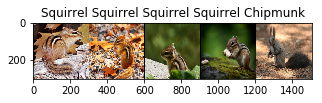

In [17]:
images, labels = iter(test_loader).next()

outputs = model(images.cuda())

_, predicted = torch.max(outputs.data, 1)
    
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(5)))

title = (' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images, normalize=True), title)